Импорт библиотекдобавление нового датасета и применение алгоритма классификации kNN. В задании был изменён датассет на более подходящий, а именно датасет про вино, где меткой служит качество вина. Так же стоит обратить внимание, что тестовых данных здесь 20%, всё остальное это данные для обучения. n_neighbors - количество соседей, которые учитываются при классификации объекта. scaler - выполняет стандартизацию данных, так как модель KNN довольно чувствительна к большому расстоянию между объектами. 

In [116]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('WineQT.csv')

X = data.drop(columns=['quality', 'Id']) 
y = data['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

Применение к датасету дерева решений. 

In [112]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

Проверка метрикой Accuracy

In [96]:
y_pred_tree = tree.predict(X_test)
y_pred_knn = knn.predict(X_test_scaled)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print(f'Accuracy (kNN): {accuracy_knn:.4f}')
print(f'Accuracy (Дерево решений): {accuracy_tree:.4f}')

Accuracy (kNN): 0.5590
Accuracy (Дерево решений): 0.5284


Проверка метрикой Precision

In [98]:
precision_knn = precision_score(y_test, y_pred_knn, average='weighted', zero_division=1)
precision_tree = precision_score(y_test, y_pred_tree, average='weighted', zero_division=1)
print(f'Precision (kNN): {precision_knn:.4f}')
print(f'Precision (Дерево решений): {precision_tree:.4f}')


Precision (kNN): 0.5477
Precision (Дерево решений): 0.5504


Проверка метрикой Recall

In [100]:
recall_knn = recall_score(y_test, y_pred_knn, average='weighted', zero_division=1)
recall_tree = recall_score(y_test, y_pred_tree, average='weighted', zero_division=1)
print(f'Recall (kNN): {recall_knn:.4f}')
print(f'Recall (Дерево решений): {recall_tree:.4f}')

Recall (kNN): 0.5590
Recall (Дерево решений): 0.5284


Проверка метрикой F1-мера (F-measure)

In [102]:
f1_knn = f1_score(y_test, y_pred_knn, average='weighted', zero_division=1)
f1_tree = f1_score(y_test, y_pred_tree, average='weighted', zero_division=1)
print(f'F1-мера (kNN): {f1_knn:.4f}')
print(f'F1-мера (Дерево решений): {f1_tree:.4f}')


F1-мера (kNN): 0.5456
F1-мера (Дерево решений): 0.5344


Проверка метрикой ROC

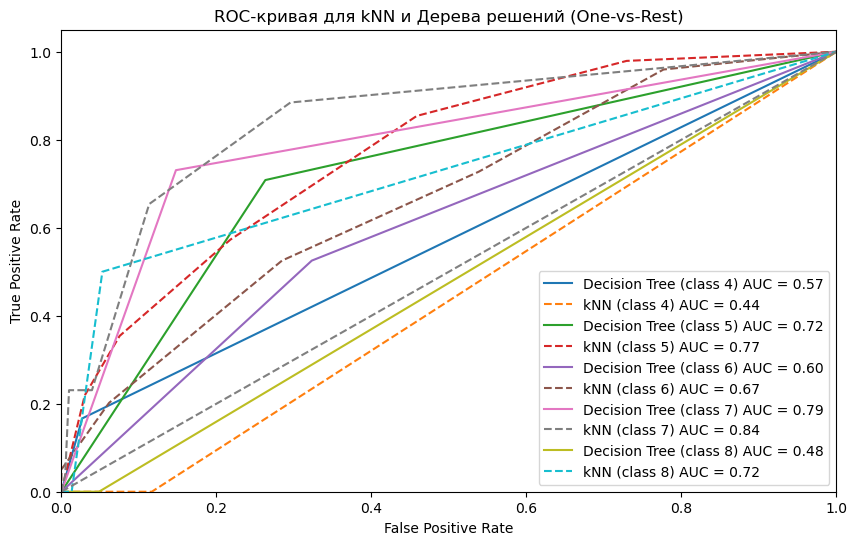

In [104]:
y_test_bin = label_binarize(y_test, classes=[3, 4, 5, 6, 7, 8])
n_classes = y_test_bin.shape[1]

tree_clf = OneVsRestClassifier(DecisionTreeClassifier(random_state=42))
tree_clf.fit(X_train_scaled, label_binarize(y_train, classes=[3, 4, 5, 6, 7, 8]))

y_score_tree = tree_clf.predict_proba(X_test_scaled)

knn_clf = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5))
knn_clf.fit(X_train_scaled, label_binarize(y_train, classes=[3, 4, 5, 6, 7, 8]))

y_score_knn = knn_clf.predict_proba(X_test_scaled)

fpr_tree = dict()
tpr_tree = dict()
roc_auc_tree = dict()

fpr_knn = dict()
tpr_knn = dict()
roc_auc_knn = dict()

for i in range(n_classes):
    if np.sum(y_test_bin[:, i]) == 0:
        continue
    fpr_tree[i], tpr_tree[i], _ = roc_curve(y_test_bin[:, i], y_score_tree[:, i], drop_intermediate=False)
    roc_auc_tree[i] = auc(fpr_tree[i], tpr_tree[i])
    
    fpr_knn[i], tpr_knn[i], _ = roc_curve(y_test_bin[:, i], y_score_knn[:, i], drop_intermediate=False)
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])

plt.figure(figsize=(10, 6))

for i in range(n_classes):
    if i in fpr_tree:
        plt.plot(fpr_tree[i], tpr_tree[i], label=f'Decision Tree (class {i+3}) AUC = {roc_auc_tree[i]:.2f}')
    if i in fpr_knn:
        plt.plot(fpr_knn[i], tpr_knn[i], label=f'kNN (class {i+3}) AUC = {roc_auc_knn[i]:.2f}', linestyle='--')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для kNN и Дерева решений (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

Как видно из результатов выполнения программы, обучение прошло относительно успешно (результат мог быть и лучше, если в качестве метки были бы бинарные данные, но так как их несколько, то угадывание усложняется), так как из тестирования удачное предсказывание случается в половине случаев, с помощью различных метрик оценки это подтвердилось, в основном метрики указывали на то, что метод KNN чуть более эффективен, хоть и для него нужны небольшие дополнительные вычисления, толко метрика Precision показала обратный результат, хотя в этой метрике различия мизерные. Метрика ROC делает провекру для всех категорий вина от 4ых до 8ми, по этому на графике такое количество линий, так как пришлось иметь дело не с бинарными данными, но график так же четко показывает примущество KNN для каждой категории вина. В среднем угадывание происходит в 50% случаев, но можно пронаблюдать что в KNN седьмой класс угадывается в разы лучше остальных, то есть данный метод анализая является самым наглядным. 